<a href="https://colab.research.google.com/github/chahatpatel2003/CSCI-167/blob/main/notebook_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)
Epoch   0 | train loss 2.287511 | train err 87.97% | val loss 2.295504 | val err 89.00%
Epoch   1 | train loss 1.990026 | train err 75.88% | val loss 2.017307 | val err 76.90%
Epoch   2 | train loss 1.611794 | train err 64.60% | val loss 1.624811 | val err 67.00%
Epoch   3 | train loss 1.388595 | train err 54.38% | val loss 1.414754 | val err 55.70%
Epoch   4 | train loss 1.336105 | train err 52.88% | val loss 1.361051 | val err 55.40%
Epoch   5 | train loss 1.099077 | train err 42.00% | val loss 1.131709 | val err 44.00%
Epoch   6 | train loss 0.946012 | train err 37

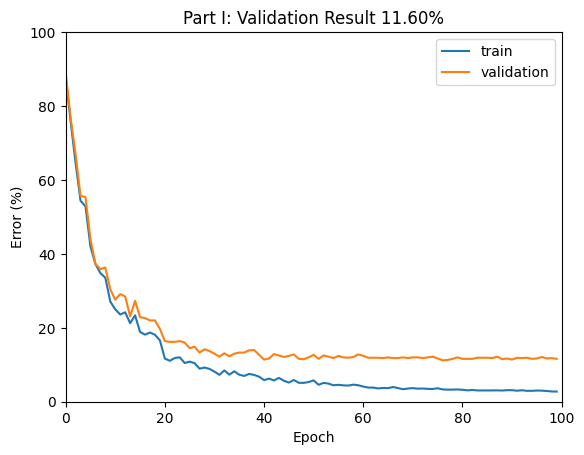

In [7]:

!pip -q install git+https://github.com/greydanus/mnist1d

import numpy as np, random, os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d


seed = 1
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

print("Examples in training set:", len(data['y']))
print("Examples in test set:", len(data['y_test']))
print("Length of each example:", data['x'].shape[-1])


train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x   = data['x_test'].transpose()
val_data_y   = data['y_test']

print("Train data: %d examples (columns), each of which has %d dimensions (rows)" %
      (train_data_x.shape[1], train_data_x.shape[0]))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)" %
      (val_data_x.shape[1],   val_data_x.shape[0]))

D_i = 40
D_o = 10


model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(inplace=True),
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(inplace=True),
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),
    nn.ReLU(inplace=True),
    nn.Flatten(),
    nn.Linear(60, D_o)
)

def weights_init(layer_in):
    if isinstance(layer_in, nn.Conv1d):
        nn.init.kaiming_uniform_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.zeros_(layer_in.bias)
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.zeros_(layer_in.bias)


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

x_train = torch.tensor(train_data_x.transpose().astype('float32'))  # (N, 40)
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val   = torch.tensor(val_data_x.transpose().astype('float32'))
y_val   = torch.tensor(val_data_y.astype('long')).long()

data_loader = DataLoader(TensorDataset(x_train, y_train),
                         batch_size=100, shuffle=True,
                         worker_init_fn=np.random.seed(1))


model.apply(weights_init)


n_epoch = 100
losses_train = np.zeros(n_epoch)
errors_train = np.zeros(n_epoch)
losses_val   = np.zeros(n_epoch)
errors_val   = np.zeros(n_epoch)

for epoch in range(n_epoch):
    model.train()
    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        pred = model(x_batch[:, None, :])
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        pred_train = model(x_train[:, None, :])
        pred_val   = model(x_val[:, None, :])

        _, predicted_train_class = torch.max(pred_train, 1)
        _, predicted_val_class   = torch.max(pred_val, 1)

        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum().item() / len(y_train)
        errors_val[epoch]   = 100 - 100 * (predicted_val_class == y_val).float().sum().item() / len(y_val)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_val[epoch]   = loss_function(pred_val, y_val).item()

    print(f'Epoch {epoch:3d} | train loss {losses_train[epoch]:.6f} | '
          f'train err {errors_train[epoch]:5.2f}% | '
          f'val loss {losses_val[epoch]:.6f} | val err {errors_val[epoch]:5.2f}%')

    scheduler.step()


fig, ax = plt.subplots()
ax.plot(errors_train, label='train')
ax.plot(errors_val,   label='validation')
ax.set_ylim(0, 100); ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error (%)')
ax.set_title(f'Part I: Validation Result {errors_val[-1]:.2f}%')
ax.legend()
plt.show()
